# Описание проекта

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных

Данные геологоразведки трёх регионов содержат следующие признаки:
-	id — уникальный идентификатор скважины;
-	f0, f1, f2 — три признака точек;
-	product — объём запасов в скважине (тыс. баррелей).

# 1. Загрузка и подготовка данных

Загрузим все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.utils import shuffle

Прочтем файлы, посмотрим на структуру данных в каждом из них.

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В каждом датафрейме по 100 тыс. строк, пропуски отсутсвуют.

Объединим данные в общий датафрейм для анализа.

In [5]:
data1 = df0.merge(df1, how='outer')
data = data1.merge(df2, how='outer')
data.describe()

,f0,f1,f2,product
count,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.547913,-1.516172,2.497439,85.441667
std,5.316634,3.900220,2.916502,46.519494
min,-31.609576,-26.358598,-12.088328,0.000000
25%,-1.003037,-2.478939,0.648213,52.666629
50%,0.347934,-0.229632,2.491215,84.038886
75%,1.755365,0.678562,4.344943,124.174086
max,29.421755,18.734063,16.739402,190.029838


Из данных видно, что все признаки могут быть как положительными так и отрицательными, почти у всех довольно большое среднеквадратичное отклонение. Что касается ключевого признака, то первое, что бросается в глаза - наличие нулей, т.е. в данных существуют скважины с нулевым запасом нефти.

Проверим, нет ли в данных дубликатов, проверять будем по id.

In [6]:
len(data['id'].unique())

299951

Дубликаты есть в кол-ве 49 штук, но они вряд ли повлияют на последующую оценку (меньше 0,02%), поэтому оставим их.

Проверим много ли "пустых" скважин.

In [7]:
data[data['product'] == 0]

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0
100011,OXyvW,16.320755,-0.562946,-0.001783,0.0
100013,igmai,6.695604,-0.749449,-0.007630,0.0
100062,Qjy5w,21.418478,-5.134490,-0.002836,0.0
100063,G6WCj,6.822701,3.104979,-0.000723,0.0
...,...,...,...,...,...
199948,Jbnur,8.277805,-9.178818,0.003275,0.0
199956,aV1cJ,13.343983,-1.290200,0.005980,0.0
199961,Zjbn2,13.854163,-11.528089,-0.005556,0.0
199973,VsayB,12.698645,-4.384673,-0.002600,0.0


8237 "пустых" скважин в трех регионах, они явно внесут большой вклад общую оценку.

Создадим функцию для рисования гистограмм по каждому из признаков.

In [8]:
def print_hist(df):
    plt.figure(figsize=[12, 8])
    sns.distplot(df['f0'], label='Признак f0')
    sns.distplot(df['f1'], label='Признак f1')
    sns.distplot(df['f2'], label='Признак f2')
    plt.legend()
    plt.show()

Нарисуем гистограммы по всем регионам.

**Для региона 0:**

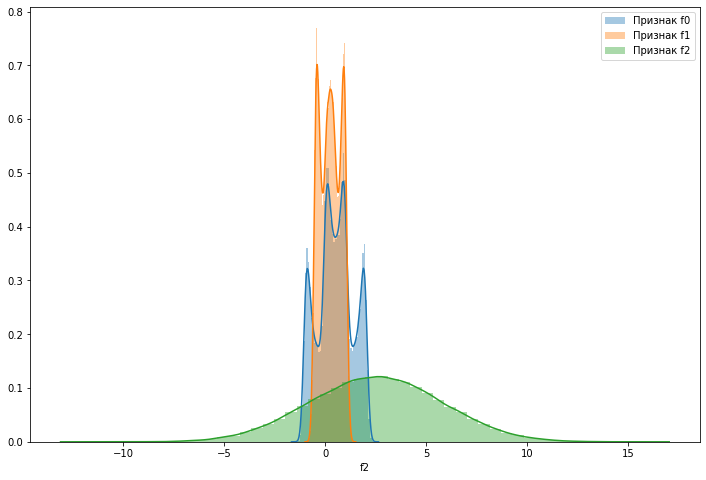

In [9]:
print_hist(df0)

**Для региона 1:**

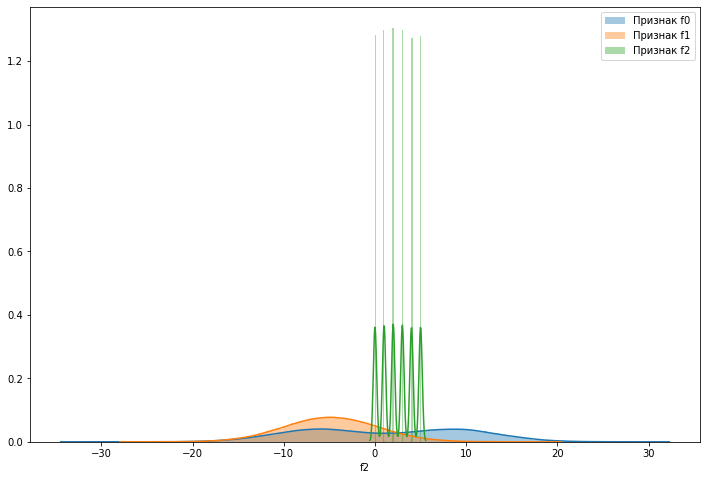

In [10]:
print_hist(df1)

**Для региона 2:**

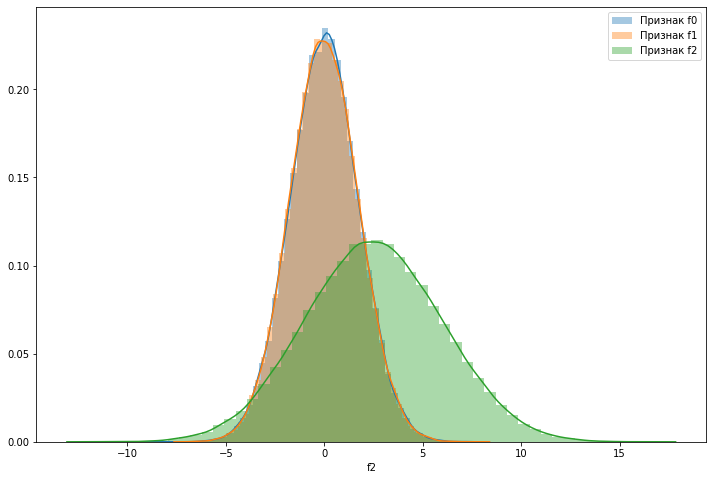

In [11]:
print_hist(df2)

**Для общего датафрейма:**

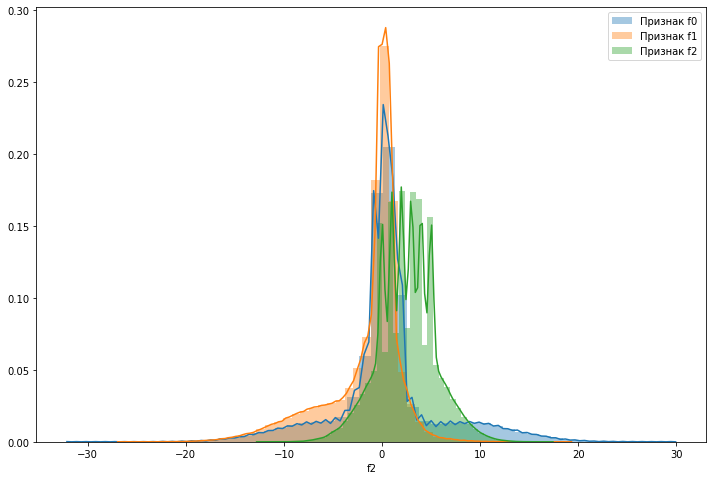

In [12]:
print_hist(data)

### Вывод:

Из всех явно выделяется только *регион 1*, если в других регионах все признаки распределены близко к нормальному, или не имеют явных выбросов, то в *регионе 1* признак *f2* распределен ступенчато с большой амплитудой (наблюдается многорбость данных), что подтверждается на общем датафрейме, где ступени сохраняются.

Посмотрим общее распределение по объемам добычи.

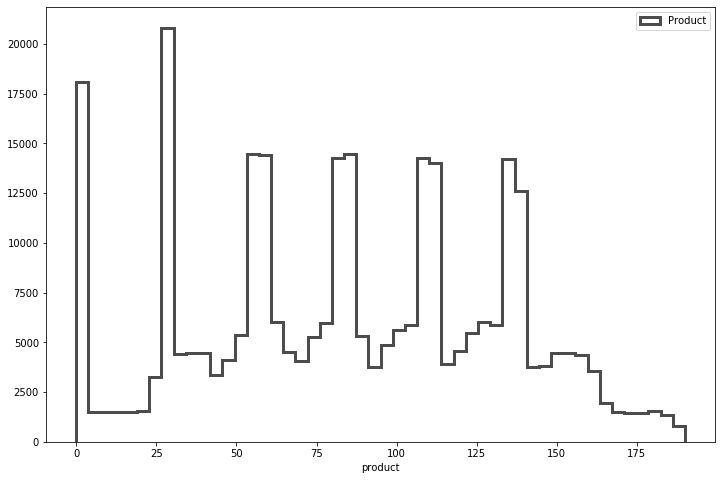

In [13]:
plt.figure(figsize=[12, 8])
sns.distplot(data['product'], kde=False, hist_kws={"histtype": "step", "linewidth": 3, 
                                                                 "alpha": .7, "color": "k"}, label='Product')
plt.legend()
plt.show()

### Вывод.

Здесь мы видим похожую структуру, которой в большей степени соответсвует признак *f2*, вероятно, он и будет самым влияющим на предсказания признаком. В свою очередь наибольшее влияние этот признак имеет в регионе 1. Отсюда можно предположить, что наилучшие предсказания будут в *регионе 1*.

Для дальнейшего обучения модели удалим из исходных датафреймов столбцы с *id*.

In [14]:
df0 = df0.drop(['id'], axis=1)
df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)

# 2. Обучение и проверка модели

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25 для каждого региона.

In [15]:
df_train0, df_valid0 = train_test_split(df0, test_size=0.25, random_state=12345)
df_train1, df_valid1 = train_test_split(df1, test_size=0.25, random_state=12345)
df_train2, df_valid2 = train_test_split(df2, test_size=0.25, random_state=12345)

Обучим модель линейной регрессии для каждого региона и выведем ключевые метрики:

- RMSE (среднеквадратическая ошибка);
- R2 (коэффициент детерминации);
- Средний запас сырья.

**Для региона 0:**

In [16]:
features_train0 = df_train0.drop(['product'], axis=1)
target_train0 = df_train0['product']
features_valid0 = df_train0.drop(['product'], axis=1)
target_valid0 = df_train0['product']

In [17]:
model0 = LinearRegression()
model0.fit(features_train0, target_train0)
predicted_valid0 = model0.predict(features_valid0)
mse = mean_squared_error(target_valid0, predicted_valid0)
rmse = mse ** 0.5
r2 = r2_score(target_valid0, predicted_valid0)
print('RMSE =', round(rmse, 2), ' | ', 'R2 =', round(r2, 2), ' | ', 'Средний запас сырья:', round(predicted_valid0.mean(), 2)) 

RMSE = 37.73  |  R2 = 0.27  |  Средний запас сырья: 92.64


**Для региона 1:**

In [18]:
features_train1 = df_train1.drop(['product'], axis=1)
target_train1 = df_train1['product']
features_valid1 = df_train1.drop(['product'], axis=1)
target_valid1 = df_train1['product']

In [19]:
model1 = LinearRegression()
model1.fit(features_train1, target_train1)
predicted_valid1 = model1.predict(features_valid1)
mse = mean_squared_error(target_valid1, predicted_valid1)
rmse = mse ** 0.5
r2 = r2_score(target_valid1, predicted_valid1)
print('RMSE =', round(rmse, 2), ' | ', 'R2 =', round(r2, 2), ' | ', 'Средний запас сырья:', round(predicted_valid1.mean(), 2)) 

RMSE = 0.89  |  R2 = 1.0  |  Средний запас сырья: 68.86


**Для региона 2:**

In [20]:
features_train2 = df_train2.drop(['product'], axis=1)
target_train2 = df_train2['product']
features_valid2 = df_train2.drop(['product'], axis=1)
target_valid2 = df_train2['product']

In [21]:
model2 = LinearRegression()
model2.fit(features_train2, target_train2)
predicted_valid2 = model2.predict(features_valid2)
mse = mean_squared_error(target_valid2, predicted_valid2)
rmse = mse ** 0.5
r2 = r2_score(target_valid2, predicted_valid2)
print('RMSE =', round(rmse, 2), ' | ', 'R2 =', round(r2, 2), ' | ', 'Средний запас сырья:', round(predicted_valid2.mean(), 2)) 

RMSE = 40.06  |  R2 = 0.2  |  Средний запас сырья: 95.04


### Вывод.

Лучше всего модель на валидации предсказывает данные по *региону 1* (самая низкая среднеквадратическая ошибка и самый высокий коэффициент детерминации), но при этом средний запас сырья в данном регионе минимальный (среди рассмотренных), поэтому нельзя однозначно сказать, что *регион 1* окажется самым прибыльным.

# 3. Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных, где *budget* - бюджет на разработку скважин в регионе, а *rev_1* - стоимость одного барреля сырья - оба значения сократим на три порядка, т.к. данные в столбце с объемом добычи даны в тысячах барелей.

При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли - обозначим это переменными *n_point* и *n_top* соответсвенно

In [22]:
budget = 1e7
rev_1 = 450
n_point = 500
n_top = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины - *suf_volume*, с учетом, что в разработку пойдут 200 скважин.

In [23]:
suf_volume = budget / rev_1
suf_volume/n_top

111.11111111111111

### Вывод.

Необходимый минимальный объем сырья для безубыточной разработки новой скважины равен 111 тыс. баррелей, тогда как средний запас сырья в каждом из регонов заметно ниже.

# 4. Расчёт прибыли и рисков 

Напишем функцию расчета прибыли по 200 скважинам с максимальными значениями предсказаний, прибыль будем считать по ключевому признаку.

In [24]:
def revenue(target, probabilities):
    probs_sorted = pd.Series(probabilities, index=target.index).sort_values(ascending=False)
    selected = target[probs_sorted.index][:n_top]
    revenue = (selected.sum() - suf_volume) * rev_1
    return revenue

Также напишем функцию для осуществления техники Bootstrap с 1000 выборок (зададим переменную n_sample), чтобы найти распределение прибыли. Сэмплирование будем проводить по 500 строк (*n_point*), т.к. столько точек исследуют при разведке региона. Расчет прибыли будет проводиться за счет ранее написанной функции *revenue*.

Внутри функции рассчитаем и выведем следующие метрики:
- средняя выручка;
- 95%-й доверительный интервал;
- вероятность убытков (как процент кол-ва отрицательных значений прибыли от общего числа).

In [25]:
n_sample = 1000

In [30]:
def bstrp(target, probabilities):
    state = np.random.RandomState(12345)   
    values = []
    for i in range(n_sample):
        target_sample = target.sample(n=n_point, replace=True, random_state=state)
        probabilities_sample = pd.Series(probabilities, index=target.index)[target_sample.index]
        rev = revenue(target_sample, probabilities_sample)
        values.append(rev)

    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    risk = (values<0).mean()
    print("Средняя выручка: {:.1f} млн руб".format(mean/1000))  
    print("95%-й доверительный интервал (млн руб): ({:.1f}, {:.1f})"
          .format(confidence_interval[0]/1000, confidence_interval[1]/1000))
    print("Вероятность убытков: {:.1%}".format(risk))

Запустим функцию для кадого из регионов.

**Регион 0:** 

In [31]:
bstrp(target_valid0, predicted_valid0)

Средняя выручка: 446.8 млн руб
95%-й доверительный интервал (млн руб): (-78.0, 952.9)
Вероятность убытков: 4.9%


**Регион 1:** 

In [32]:
bstrp(target_valid1, predicted_valid1)

Средняя выручка: 462.4 млн руб
95%-й доверительный интервал (млн руб): (72.3, 880.3)
Вероятность убытков: 1.3%


**Регион 2:** 

In [33]:
bstrp(target_valid2, predicted_valid2)

Средняя выручка: 374.4 млн руб
95%-й доверительный интервал (млн руб): (-172.2, 856.7)
Вероятность убытков: 8.8%


# Вывод.

По предварительному анализу, оценке качества модели и оценке трех основных показателей (средняя выручка, 95%-й доверительный интервал и вероятность убытков), полученных техникой Bootstrap с 1000 выборок, под необходимые критерии (вероятность убытка меньше 2,5%) подходит только **регион 1** со следующими показателями:
- Средняя выручка: 446.8 млн руб
- 95%-й доверительный интервал (млн руб): (72.3, 880.3)
- Вероятность убытков: 4.9%

Для остальных регионов вероятность убытка выше 2,5% при этом ниже средняя выручка, поэтому для разработки скважин можно рекомендовать только **регион 1**.